In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

import tensorflow_hub as hub
import os

from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

2.7.0


In [ ]:
!unzip -uq "/content/drive/MyDrive/DATASETS_INCEPTION/SKCANCER.zip" -d "/content"

In [ ]:
from os import getcwd

In [ ]:
#1

path_dataset = f"{getcwd()}/../content/drive/MyDrive/DATASETS_INCEPTION/SKCANCER.zip"


In [ ]:

from zipfile import ZipFile
file_name = path_dataset

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')



Done


In [ ]:

import os 
melignant = os.path.join('../content/SKCANCER/malignant')
benign = os.path.join('../content/SKCANCER/benign')
print('Total malignant Images:',len(os.listdir(melignant)))
print('Total benign Images:',len(os.listdir(benign)))

Total malignant Images: 1497
Total benign Images: 1800


In [ ]:
#3

malignant_files = os.listdir(melignant)
print(malignant_files[:10])
benign_files = os.listdir(benign)
print(benign_files[:10])

['799.jpg', '1141.jpg', '644.jpg', '896.jpg', '1404.jpg', '1105.jpg', '1331.jpg', '782.jpg', '904.jpg', '556.jpg']
['1615.jpg', '799.jpg', '1141.jpg', '644.jpg', '896.jpg', '1404.jpg', '1105.jpg', '1667.jpg', '1331.jpg', '782.jpg']


In [ ]:

from glob import glob
import os.path
from shutil import copy2

path = '../content/SKCANCER'
test = '../content/Test'
train = '../content/Train'

if not os.path.exists(test):
	os.makedirs(test)
if not os.path.exists(train):
	os.makedirs(train)
 
for folder in glob(path+'/*'):
		print(folder)
		# find number of images in folder
		no_images_in_folder = len(os.listdir(folder))
		# make new folder inside test and train
		folder_test = test+'/'+folder.split('/')[3]+'/'
		folder_train = train+'/'+folder.split('/')[3]+'/'
		# print(folder_test)
		# print(folder_train)
		if not os.path.exists(folder_test):
			os.makedirs(folder_test)
		if not os.path.exists(folder_train):
			os.makedirs(folder_train)

		print("no of images in this folder: {}".format(no_images_in_folder))
		train_num = int(no_images_in_folder*0.8)
		
		
		for idx, im in enumerate(glob(folder+'/*')):
			
			if idx <= train_num:
		
				copy2(im, folder_train)
			else:
			
				copy2(im, folder_test)


../content/SKCANCER/malignant
no of images in this folder: 1497
../content/SKCANCER/benign
no of images in this folder: 1800


In [ ]:
train_dir = '/content/Train'
validation_dir = '/content/Test'

train_malignant_dir = os.path.join(train_dir,'malignant')
train_benign_dir = os.path.join(train_dir,'benign')
validation_malignant_dir = os.path.join(validation_dir,'malignant')
validation_benign_dir = os.path.join(validation_dir,'benign')

train_malignant_fnames = os.listdir(train_malignant_dir)
train_benign_fnames = os.listdir(train_benign_dir)
validation_malignant_fnames = os.listdir(validation_malignant_dir)
validation_benign_fnames = os.listdir(validation_benign_dir)

print(len(train_malignant_fnames))
print(len(train_benign_fnames))
print(len(validation_malignant_fnames))
print(len(validation_benign_fnames))

1198
1441
299
359


In [ ]:
Labels = ['benign', 'malignant']

In [ ]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i])

class : 
0 benign
1 malignant


In [ ]:
print('Number of classes:',len(Labels))

Number of classes: 2


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32

In [ ]:
IMAGE_SIZE

(224, 224)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,  
        target_size=(224,224), 
        batch_size=32,
        class_mode='binary')

validation_generator =  test_datagen.flow_from_directory( validation_dir,  
        target_size=(224,224), 
        batch_size=32,
        class_mode='binary')


Found 2639 images belonging to 2 classes.
Found 658 images belonging to 2 classes.


In [ ]:
IMAGE_SIZE = 224
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

#Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1 , activation='sigmoid')

In [ ]:
model = tf.keras.Sequential([base_model,
                             global_average_layer,
                             prediction_layer
                             ])

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
EPOCHS=15
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.samples//train_generator.batch_size,
                              epochs=EPOCHS,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.samples//validation_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


82/82 [==============================] - 121s 1s/step - loss: 0.5205 - accuracy: 0.7376 - val_loss: 0.4997 - val_accuracy: 0.7375
Epoch 2/15
82/82 [==============================] - 117s 1s/step - loss: 0.4299 - accuracy: 0.8036 - val_loss: 0.4302 - val_accuracy: 0.8156
Epoch 3/15
82/82 [==============================] - 117s 1s/step - loss: 0.4067 - accuracy: 0.8082 - val_loss: 0.4213 - val_accuracy: 0.7906
Epoch 4/15
82/82 [==============================] - 117s 1s/step - loss: 0.3970 - accuracy: 0.8193 - val_loss: 0.3883 - val_accuracy: 0.8328
Epoch 5/15
82/82 [==============================] - 117s 1s/step - loss: 0.3750 - accuracy: 0.8354 - val_loss: 0.3789 - val_accuracy: 0.8391
Epoch 6/15
82/82 [==============================] - 116s 1s/step - loss: 0.3720 - accuracy: 0.8377 - val_loss: 0.3642 - val_accuracy: 0.8359
Epoch 7/15
82/82 [==============================] - 117s 1s/step - loss: 0.3644 - accuracy: 0.8339 - val_loss: 0.3644 - val_accuracy: 0.8422
Epoch 8/15
82/82 [======

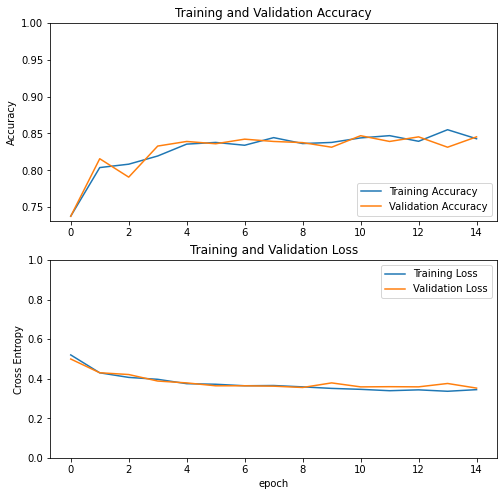

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
### fine tuning

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:


fine_tune_epochs = 20
initial_epochs =  history.epoch[-1]

total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch=train_generator.samples//train_generator.batch_size,
                                   epochs=total_epochs,
                                   validation_data=validation_generator,
                                   validation_steps=validation_generator.samples//validation_generator.batch_size
                                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/34


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


82/82 [==============================] - 198s 2s/step - loss: 0.5117 - accuracy: 0.7733 - val_loss: 0.5835 - val_accuracy: 0.7719
Epoch 2/34
82/82 [==============================] - 191s 2s/step - loss: 0.3507 - accuracy: 0.8420 - val_loss: 0.5437 - val_accuracy: 0.7906
Epoch 3/34
82/82 [==============================] - 189s 2s/step - loss: 0.3028 - accuracy: 0.8730 - val_loss: 0.5743 - val_accuracy: 0.7812
Epoch 4/34
82/82 [==============================] - 189s 2s/step - loss: 0.2705 - accuracy: 0.8838 - val_loss: 0.4434 - val_accuracy: 0.8188
Epoch 5/34
82/82 [==============================] - 189s 2s/step - loss: 0.2497 - accuracy: 0.8895 - val_loss: 0.5796 - val_accuracy: 0.7797
Epoch 6/34
82/82 [==============================] - 189s 2s/step - loss: 0.2382 - accuracy: 0.8984 - val_loss: 1.3059 - val_accuracy: 0.6734
Epoch 7/34
82/82 [==============================] - 188s 2s/step - loss: 0.2190 - accuracy: 0.9079 - val_loss: 1.2712 - val_accuracy: 0.6812
Epoch 8/34
82/82 [======

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

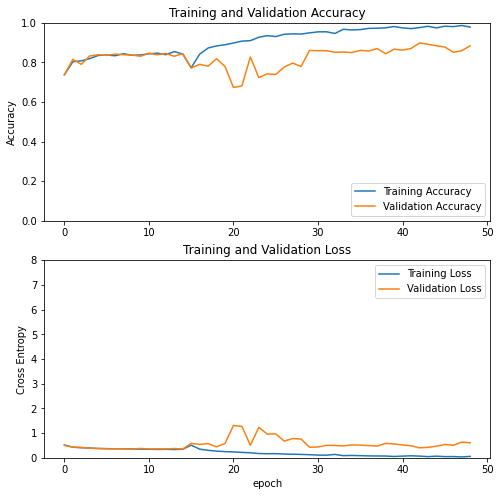

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,8.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()